* Mineria de datos


Se importan las librerias que vamos a usar

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go


Se lee la base de datos y se eliminan las filas vacias de las columnas Rating y Reviews

In [46]:
df = pd.read_csv("Amazon_Unlocked_Mobile.csv")
df.dropna(subset=["Rating", "Reviews"], inplace=True)

In [47]:
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413770 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413770 non-null  object 
 1   Brand Name    348616 non-null  object 
 2   Price         407840 non-null  float64
 3   Rating        413770 non-null  int64  
 4   Reviews       413770 non-null  object 
 5   Review Votes  401474 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 22.1+ MB


Se crea una columna binaria Calidad para clasificar productos como buenos (1) o malos (0).

In [49]:
#Positivos o negativos
df['Calidad'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)


Se grafica la cantidad de productos buenos y malos.

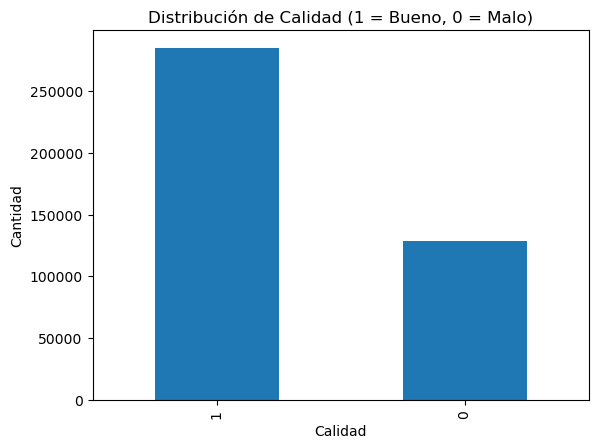

In [50]:
df['Calidad'].value_counts().plot(kind='bar')
plt.xlabel('Calidad')
plt.ylabel('Cantidad')
plt.title('Distribución de Calidad (1 = Bueno, 0 = Malo)')
plt.show()


Se convierte la columna de reseñas en una matriz numérica

In [51]:
# Vectorizar Reviews
vectorizer = TfidfVectorizer(max_features=100)  
X_reviews = vectorizer.fit_transform(df['Reviews'].astype(str))




Se separan los datos en conjuntos de entrenamiento y prueba, manteniendo la proporción de clases.

In [52]:

y = df['Calidad']

# Divide en train y test manteniendo la proporción de clases con stratify
X_train, X_test, y_train, y_test = train_test_split(
    X_reviews, y, test_size=0.2, random_state=42, stratify=y
)

Se entrena el modelo con decision tree

In [53]:
# Crear el modelo
modelo_arbol = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo
modelo_arbol.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

Se predice y se muestran métricas de desempeño del modelo base.

In [54]:

# Predecir en el conjunto de prueba
y_pred = modelo_arbol.predict(X_test)

# Accuracy y reporte de clasificación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.9110375329289219
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     25764
           1       0.92      0.95      0.94     56990

    accuracy                           0.91     82754
   macro avg       0.90      0.89      0.89     82754
weighted avg       0.91      0.91      0.91     82754



Gráfica para poder ver cuantos tuvo correcto y cuantos incorrectos tanto con el 1 como el 0. Esto así para poder exactamente los correctos y los incorrectos.

In [55]:

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
labels = ["Malo (0)", "Bueno (1)"]

# Crear la figura
fig = ff.create_annotated_heatmap(
    z=cm,
    x=labels,
    y=labels,
    colorscale='Blues',
    showscale=True
)
fig.update_layout(
    title="Matriz de Confusión",
    xaxis_title="Predicción",
    yaxis_title="Real"
)
fig.show()

Se hace una gráfica de barras para poder comparar los valores reales y los predichos.

In [56]:


# Contar valores reales y predichos
real_counts = y_test.value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()

# Crear la gráfica de barras
fig = go.Figure(data=[
    go.Bar(name='Reales', x=['0', '1'], y=[real_counts.get(0, 0), real_counts.get(1, 0)]),
    go.Bar(name='Predichos', x=['0', '1'], y=[pred_counts.get(0, 0), pred_counts.get(1, 0)])
])

fig.update_layout(
    barmode='group',
    title='Comparación de cantidad de 0 y 1: Reales vs Predichos',
    xaxis_title='Clase',
    yaxis_title='Cantidad'
)
fig.show()

Se agrega la función de busqueda de hiperparámetros para poder encontrar el mejor árbol de decisión.

In [ ]:
param_grid = {
    'max_depth': [10,  None],      
    'min_samples_split': [2, 5],       
    'min_samples_leaf': [1, 2]          
}
# Crear el modelo base
dtree = DecisionTreeClassifier(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Predecir con el mejor modelo
y_pred = best_model.predict(X_test)
# Métricas
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

c:\Users\mario\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


14 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mario\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mario\miniconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mario\miniconda3\Lib\site-packages\sklearn\tree\_classes.py", line 1024, in fit
    super()._fit(
 

Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.9110375329289219
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     25764
           1       0.92      0.95      0.94     56990

    accuracy                           0.91     82754
   macro avg       0.90      0.89      0.89     82754
weighted avg       0.91      0.91      0.91     82754



Matriz para poder ver los resultados predichos, los correctos e incorrectos.

In [ ]:
#Matriz ahora con grid search
cm = confusion_matrix(y_test, y_pred)
labels = ["Malo (0)", "Bueno (1)"]

fig = ff.create_annotated_heatmap(
    z=cm,
    x=labels,
    y=labels,
    colorscale='Blues',
    showscale=True
)
fig.update_layout(
    title="Matriz de Confusión (GridSearch)",
    xaxis_title="Predicción",
    yaxis_title="Real"
)
fig.show()

De igual manera las gráfica para comparar los reales con los predichos

In [ ]:
#Graficar la comparación de cantidades reales y predichas con GridSearch
real_counts = y_test.value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()

fig = go.Figure(data=[
    go.Bar(name='Reales', x=['0', '1'], y=[real_counts.get(0, 0), real_counts.get(1, 0)]),
    go.Bar(name='Predichos', x=['0', '1'], y=[pred_counts.get(0, 0), pred_counts.get(1, 0)])
])

fig.update_layout(
    barmode='group',
    title='Comparación de cantidad de 0 y 1: Reales vs Predichos (GridSearch)',
    xaxis_title='Clase',
    yaxis_title='Cantidad'
)
fig.show()

Se modifican los parámetros para ver si mejora o disminuye el accuracy.

In [60]:
#Segundos parámetros
param_grid = {
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [2]
}

# Crear el modelo base
dtree = DecisionTreeClassifier(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    cv=4,
    scoring='accuracy',
    n_jobs=-1
)

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Predecir con el mejor modelo
y_pred = best_model.predict(X_test)
# Métricas
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy: 0.8997389854266863
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     25764
           1       0.92      0.93      0.93     56990

    accuracy                           0.90     82754
   macro avg       0.88      0.88      0.88     82754
weighted avg       0.90      0.90      0.90     82754



Misma gráfica

In [61]:
#Matriz ahora con grid search
cm = confusion_matrix(y_test, y_pred)
labels = ["Malo (0)", "Bueno (1)"]

fig = ff.create_annotated_heatmap(
    z=cm,
    x=labels,
    y=labels,
    colorscale='Blues',
    showscale=True
)
fig.update_layout(
    title="Matriz de Confusión (GridSearch)",
    xaxis_title="Predicción",
    yaxis_title="Real"
)
fig.show()

Misma gráfica

In [62]:
#Graficar la comparación de cantidades reales y predichas con GridSearch
real_counts = y_test.value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()

fig = go.Figure(data=[
    go.Bar(name='Reales', x=['0', '1'], y=[real_counts.get(0, 0), real_counts.get(1, 0)]),
    go.Bar(name='Predichos', x=['0', '1'], y=[pred_counts.get(0, 0), pred_counts.get(1, 0)])
])

fig.update_layout(
    barmode='group',
    title='Comparación de cantidad de 0 y 1: Reales vs Predichos (GridSearch)',
    xaxis_title='Clase',
    yaxis_title='Cantidad'
)
fig.show()